#  Stochastic Volatility
the first part of the code

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
from pymc3.variational.callbacks import CheckParametersConvergence
import scipy as sc
import matplotlib.pyplot as plt #for plots
%matplotlib inline
import statsmodels.api as sm
plt.style.use('ggplot')
print('Running with PyMC3 version v.{}'.format(pm.__version__))

Running with PyMC3 version v.3.6


import color map

In [2]:
import brewer2mpl
bmap = brewer2mpl.get_map('Set2', 'qualitative', 8)
colors = bmap.mpl_colors

## Data
download data thourgh yahoo's API

In [3]:
from pandas_datareader import data
returns=data.get_data_yahoo('SPY',start='2018-3-22',end='2019-3-22')['Adj Close'].pct_change()
#Percentage change between the current and a prior element.
print(len(returns))

252


## The trace-plot of daily percent change of S&P500 from March 2018 to March 2019.

Text(0.5, 0, 'Date')

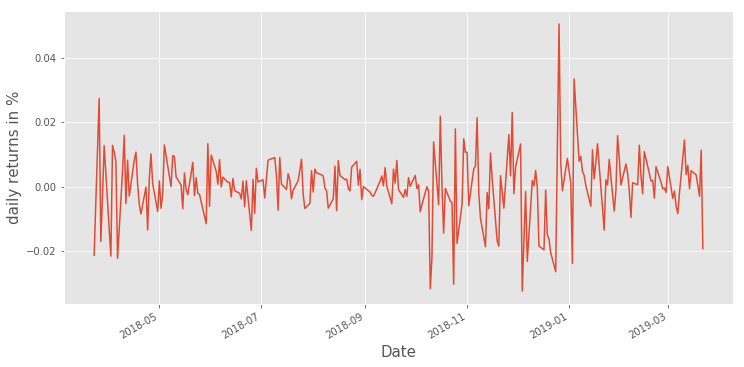

In [32]:
returns.plot(figsize=(12, 6));
plt.ylabel('daily returns in %', fontsize = 15);
plt.xlabel('Date', fontsize = 15)

## model
defined the model according to paper

In [4]:
with pm.Model() as sp500_model:
    sigma = pm.Exponential('sigma',50.0)
    nu=pm.Exponential('nu',0.1)
    s=pm.distributions.timeseries.GaussianRandomWalk('s',sigma**-2,shape=len(returns))
    volatility_process=pm.Deterministic('volatility_process',pm.math.exp(-2*s))
    r=pm.StudentT('r',nu,0,1.0/volatility_process,observed=returns)

/anaconda3/lib/python3.7/site-packages/pymc3/model.py:1266: UserWarning: Data in r contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)


In [5]:
with sp500_model:
    trace = pm.sample(100000, callbacks=[CheckParametersConvergence()])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r_missing, s, nu, sigma]
Sampling 4 chains: 100%|██████████| 402000/402000 [1:00:35<00:00, 110.59draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [6]:
sum_pm = pm.summary(trace)

In [71]:
sum_pm[sum_pm.index == 'sigma'] # the summary of sigma

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,0.096814,0.021376,0.000214,0.057434,0.140006,9936.024681,1.000227


In [68]:
sum_pm[sum_pm.index == 'nu'] # the summary of nu

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
nu,17.295222,10.431711,0.023705,3.766212,38.106866,219005.934967,0.999999


In [76]:
pm.diagnostics.effective_n(trace,  varnames = ['sigma'])

{'sigma': 9936.024680852248}

The traceplots for the whole process, it seemed that all chains were converged.

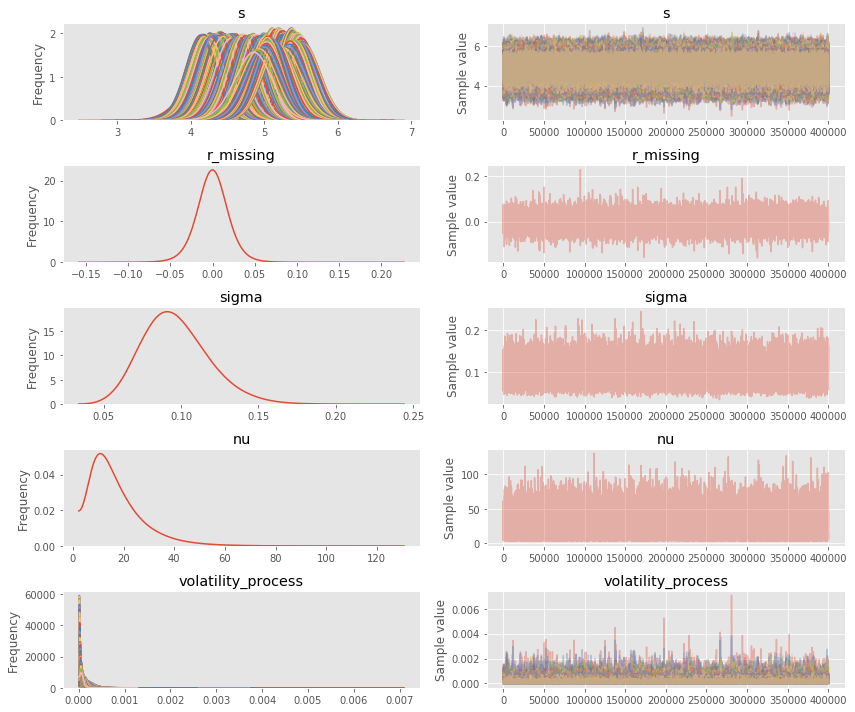

In [17]:
pm.traceplot(trace);

The sigma and nu are two parameters which we are concered, the left two plots are density plots, the solid lines are posterior distribution and dashed lines are prior distribution; the right two plots are trace plots, because of multiprocess sampling (i.e. 4 chains), there are 4 colors lines here.

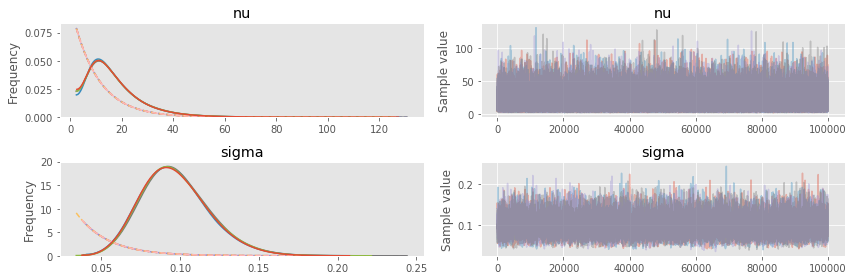

In [73]:
pm.traceplot(trace,[nu,sigma], priors=[nu.distribution,sigma.distribution]);

The autocorrelation plot of σ in 4 chains:

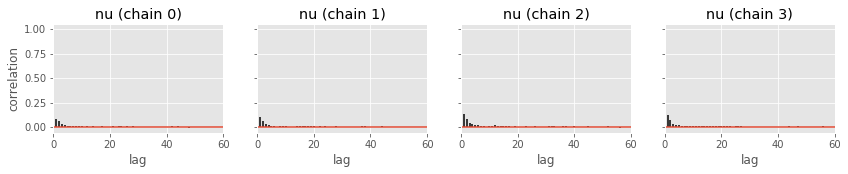

In [61]:
pm.plots.autocorrplot(trace, varnames = ['nu'], max_lag = 60, figsize = (14,2));

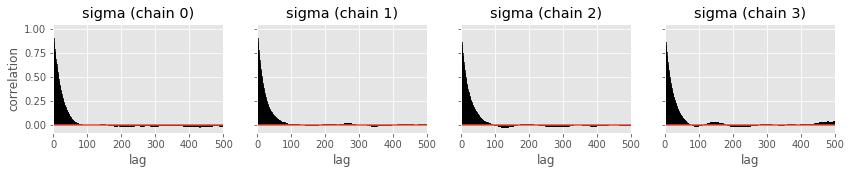

In [62]:
pm.plots.autocorrplot(trace, varnames = ['sigma'], max_lag = 500, figsize = (14,2));

The posterior plots of ν and σ: 

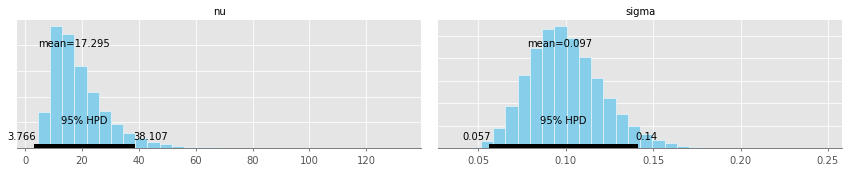

In [20]:
pm.plots.plot_posterior(trace, varnames = ['nu','sigma']);

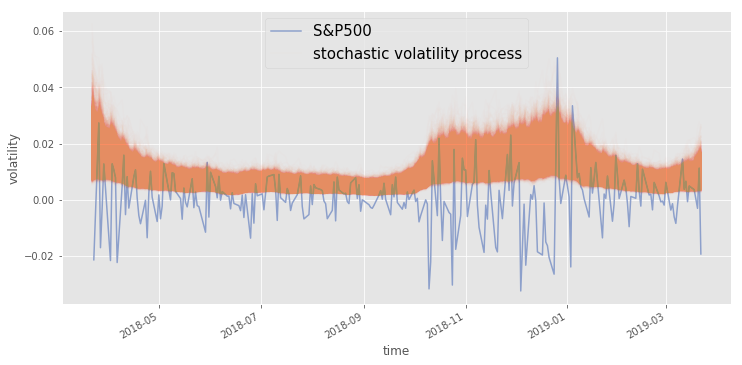

In [78]:
fig,ax=plt.subplots(figsize=(12,6));
returns.plot(ax=ax,color = colors[2]);
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), color = colors[1], alpha=.01);
ax.set(xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process'], fontsize = 15);

The red dashed line are 95 % credible intervals, and green areas are superposition of 100000 sampled traces, so the more overlapping part of the deeper the color.

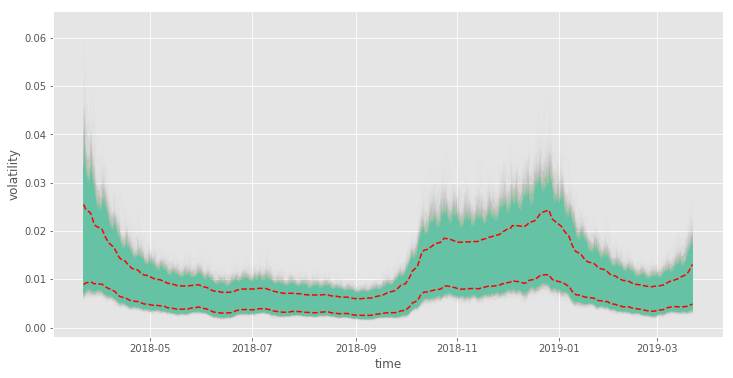

In [33]:
fig,ax=plt.subplots(figsize=(12,6));
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), color = colors[0], alpha=.005,label='ss');
ax.plot(returns.index, 1/np.exp(sum_pm["hpd_2.5"][:252]), color = 'r',linestyle='dashed',label='credible interval');
ax.plot(returns.index, 1/np.exp(sum_pm["hpd_97.5"][:252]), color = 'r',linestyle='dashed');
ax.set(xlabel='time', ylabel='volatility');
#ax.legend(['credible interval', 'stochastic volatility process'],fontsize = 15);

Posterior Predictive Checks

In [16]:
ppc = pm.sample_posterior_predictive(trace, samples=1000, model=sp500_model)
np.asarray(ppc['r']).shape

100%|██████████| 1000/1000 [00:00<00:00, 1678.70it/s]


(1000, 252)

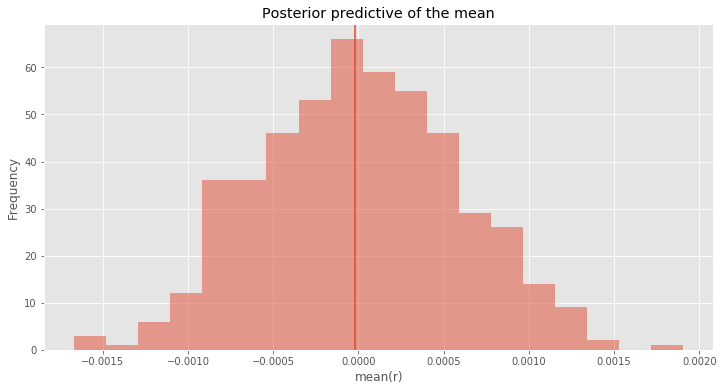

In [89]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in ppc['r']], bins=19, alpha=0.5)
ax.axvline(trace["r_missing"].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(r)', ylabel='Frequency');

#  Pima Indians Diabetes Database

In [2]:
import random
import math
import itertools
import seaborn as sns
import csv

Training Data and Test Data

In [5]:
filename = 'pima-indians-diabetes-data.csv'
lines = csv.reader(open(filename, "r"))
dataset = list(lines)
for i in range(len(dataset)):
    dataset[i] = [float(x) for x in dataset[i]]
df = pd.read_csv("diabetes.csv")

Scaling the data

In [6]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X =  pd.DataFrame(sc_X.fit_transform(df.drop(["Outcome"],axis = 1),),
        columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'])
y = df.Outcome
df_scale = X.join(y)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


The correlation matrix plot of Pearson’s Correlation Coefficients among variables.

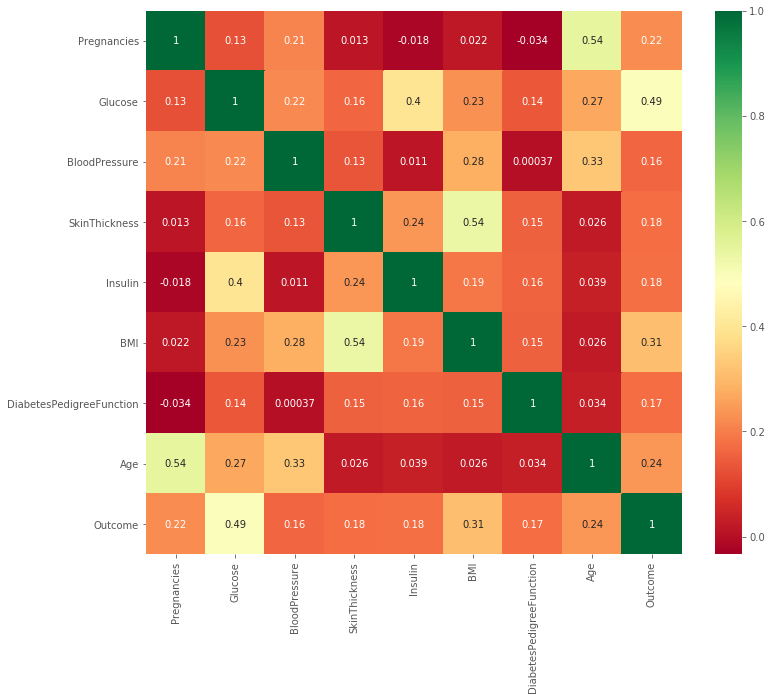

In [7]:
plt.figure(figsize=(12,10))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(df.corr(), annot=True,cmap ='RdYlGn')  # seaborn has very simple solution for heatmap

split data into training data and test data

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=42, stratify=y)
trainSet = X_train.join(y_train).values.tolist()
testSet = X_test.join(y_test).values.tolist()
print('Split {0} rows into train={1} and test={2} rows'.format(len(dataset), len(trainSet), len(testSet)))

Split 768 rows into train=512 and test=256 rows


## Naive Bayes
I defined a series functions to get the result of naive bayes.


First, the samples in the training data set are divided into categories, and then the statistics of each class are calculated. We can create a mapping of categories to sample lists belonging to this category and classify the samples in the entire data set into corresponding lists.

In [2]:
def separateByClass(dataset):
    separated = {}
    for i in range(len(dataset)):
        vector = dataset[i]
        if (vector[-1] not in separated):
            separated[vector[-1]] = []
        separated[vector[-1]].append(vector)
    return separated

Calculating the mean and stand deviation:

In [3]:
def mean(numbers):
    return sum(numbers)/float(len(numbers))

def stdev(numbers):
    avg = mean(numbers)
    variance = sum([pow(x-avg,2) for x in numbers])/float(len(numbers)-1)
    return math.sqrt(variance)

Now we can extract the dataset features. For a given sample list (corresponding to a class), we can calculate the mean and standard deviation of each attribute.


In [ ]:
def summarize(dataset):
    summaries = [(mean(attribute), stdev(attribute)) for attribute in zip(*dataset)]
    del summaries[-1]
    return summaries

Then, we first divide the training data set by category and then calculate a summary of each attribute.

In [ ]:
def summarizeByClass(dataset):
    separated = separateByClass(dataset)
    summaries = {}
    for classValue, instances in separated.items():
        summaries[classValue] = summarize(instances)
    return summaries


Calculating the Gaussian probability density function;

Given the mean and standard deviation from the known properties in the training data, we can use the Gaussian function to estimate the probability of a given property value.

In [ ]:
def calculateProbability(x, mean, stdev):
    exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
    return (1 / (math.sqrt(2*math.pi) * stdev)) * exponent


Since we can calculate the probability that an attribute belongs to a class, then the probability of combining all the attributes in a data sample, and finally the probability that the entire data sample belongs to a class.

In [ ]:
def calculateClassProbabilities(summaries, inputVector):
    probabilities = {}
    for classValue, classSummaries in summaries.items():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, stdev = classSummaries[i]
            x = inputVector[i]
            probabilities[classValue] *= calculateProbability(x, mean, stdev)
    return probabilities


Since we can calculate the probability that a data sample belongs to each class, we can find the largest probability value and return the associated class.

In [4]:
def predict(summaries, inputVector):
    probabilities = calculateClassProbabilities(summaries, inputVector)
    bestLabel, bestProb = None, -1
    for classValue, probability in probabilities.iteritems():
        if bestLabel is None or probability > bestProb:
            bestProb = probability
            bestLabel = classValue
    return bestLabel


Finally, by predicting each data sample in the test data set, we can evaluate the model accuracy. The getPredictions() function implements this function and returns a list of predictions for each test sample.

In [ ]:
def getPredictions(summaries, testSet):
    predictions = []
    for i in range(len(testSet)):
        result = predict(summaries, testSet[i])
        predictions.append(result)
    return predictions
predictions = getPredictions(summaries, testSet)


The predicted value is compared with the category value in the test data set, and an accuracy between 0% and 100% can be calculated as the classification accuracy. The getAccuracy() function can calculate this precision.

In [11]:
def getAccuracy(testSet, predictions):
    correct = 0
    for i in range(len(testSet)):
        if testSet[i][-1] == predictions[i]:
            correct += 1
    return (correct/float(len(testSet))) * 100.0
accuracy = getAccuracy(testSet, predictions)
print('Accuracy: {0}%'.format(accuracy))

Accuracy: 72.65625%


In [12]:
from sklearn.metrics import classification_report, confusion_matrix  
test = [x[-1] for x in testSet]
print(confusion_matrix(test, predictions))  
print(classification_report(test, predictions))  

[[128  39]
 [ 31  58]]
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79       167
         1.0       0.60      0.65      0.62        89

   micro avg       0.73      0.73      0.73       256
   macro avg       0.70      0.71      0.70       256
weighted avg       0.73      0.73      0.73       256



Text(0.5, 15.0, 'Predicted label')

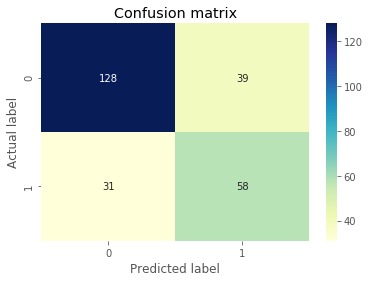

In [17]:
y_pred = knn.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(test, predictions)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [14]:
def calculateClassProbabilities(summaries, inputVector):
    probabilities = {}
    for classValue, classSummaries in summaries.items():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, stdev = classSummaries[i]
            x = inputVector[i]
            probabilities[classValue] *= calculateProbability(x, mean, stdev)
    return probabilities

def predict(summaries, inputVector):
    probabilities = calculateClassProbabilities(summaries, inputVector)
    bestLabel, bestProb = None, -1
    for classValue, probability in probabilities.items():
        if bestLabel is None or probability > bestProb:
            bestProb = probability
            bestLabel = classValue
    return bestLabel, bestProb
 
def getPredictions(summaries, testSet):
    predictions = []
    scores = []
    for i in range(len(testSet)):
        result,score = predict(summaries, testSet[i])
        scores.append(score)
        predictions.append(result)
    return predictions, scores

predictions, scores= getPredictions(summaries, testSet)

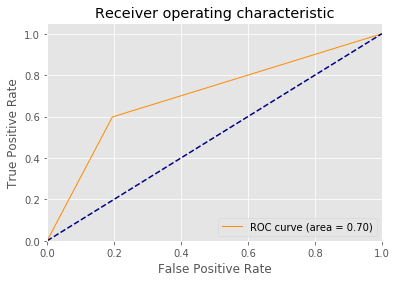

In [15]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(predictions, test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
test_scores = []
train_scores = []
for i in range(1,15):
    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [18]:
## score that comes from testing on the same datapoints that were used for training
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 100.0 % and k = [1]


In [19]:
## score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 74.609375 % and k = [11]


The cross validation plot for KNN classification: 

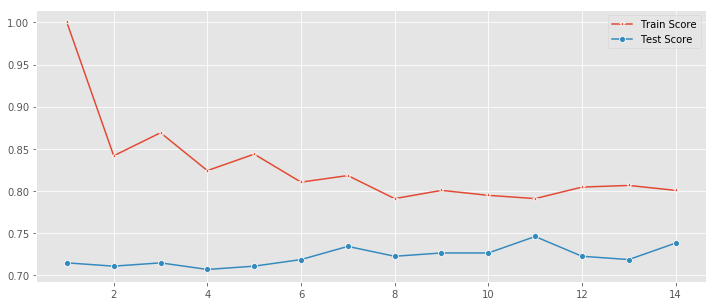

In [20]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,15),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,15),test_scores,marker='o',label='Test Score')

In [21]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(11)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.74609375

In [22]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       167
           1       0.67      0.48      0.56        89

   micro avg       0.74      0.74      0.74       256
   macro avg       0.72      0.68      0.69       256
weighted avg       0.73      0.74      0.73       256



Text(0.5, 15.0, 'Predicted label')

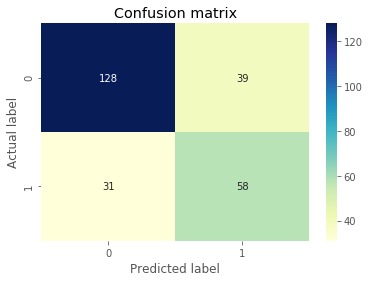

In [23]:
y_pred = knn.predict(X_test)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(test, predictions)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
#Area under ROC curve
roc_auc = roc_auc_score(y_test,y_pred_proba)

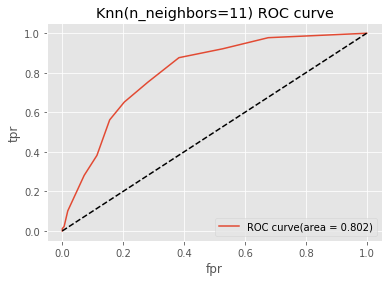

In [25]:
plt.plot(fpr,tpr, label='Knn')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=11) ROC curve')
#plt.text(0.5, 0.1, 'ROC curve (area =' + str(round(auc,3)) + ')', fontsize = 15)
plt.legend(["ROC curve(area = "+str(round(roc_auc,3)) + ")"], loc="lower right")
plt.show()